# Measuring Radial Velocities

In this tutorial we will learn how to derive radial velocities from a series of spectra.

We will use the cross-correlation technique to measure the velocities. You can think of this technique of sliding a model spectrum across the observed spectrum as a range of velocity shifts. At each velocity shift you multiply the model by the observed spectrum and sum up the values. When the model lines up with the observed spectrum you see a peak in this cross correlation value. The final velocity is extracted by plotting the cross correlation value as a function of velocity offset and precisely locating the peak.

In this example our 'model' will be the first spectra in a series of spectra and we will calculate the velocity shifts for each spectrum relative to the first spectrum.

In [1]:
# Import some required libraries
import numpy as np
from numpy import ma
from scipy.interpolate import InterpolatedUnivariateSpline
import pandas as pd
import pylab as pl
from glob import glob
import os
import matplotlib.pyplot as plt
from scipy.stats import norm

SPEED_OF_LIGHT = 2.99792e5 # Speed of light [km/s] 

In [2]:
# Here we define some functions that will be needed later for the cross correlation

def wav_to_dvel(wav):
    """Converts wavelengths to delta velocities using doppler formula"""
    dvel = (wav[1:] - wav[:-1]) / (wav[1:]) * SPEED_OF_LIGHT
    return dvel

def loglambda(wav0, flux0):
    """Resample spectrum onto a constant log-lambda wavelength scale

    Args:
        wav0 (array): array of wavelengths
        flux0 (array): flux values at wav0
    
    Returns:
        wav (array): wavelengths (constant log-spacing)
        flux (array): flux values at wav
        dvel (float): spacing between measurements in velocity space (km/s)
    """
    assert wav0.shape == flux0.shape, "wav0 and flux must be same size"
    npix = wav0.size
    wav = np.logspace(np.log10(wav0[0]), np.log10(wav0[-1]), wav0.size)
    spline = InterpolatedUnivariateSpline(wav0, flux0)
    flux = spline(wav)
    dvel = wav_to_dvel(wav)
    dvel = np.mean(dvel)
    return wav, flux, dvel


In [3]:
# Load the series of spectra into list.
# You may need to modify the path to the sample spectra.
# Each spectra file has two columns, one for wavelength and one for flux.
# We will use pandas.read_csv to load the files.

series = []
file_list = sorted(glob('../../synthetic_spectra/*.csv'))
for f in file_list:
    print(f)
    spec = pd.read_csv(f)
        
    series.append(spec)


../../synthetic_spectra/5800K+00.csv
../../synthetic_spectra/5800K+05.csv
../../synthetic_spectra/5800K+10.csv
../../synthetic_spectra/5800K+15.csv
../../synthetic_spectra/5800K+20.csv
../../synthetic_spectra/5800K-05.csv
../../synthetic_spectra/5800K-10.csv
../../synthetic_spectra/5800K-15.csv
../../synthetic_spectra/5800K-20.csv


First lets plot the first spectrum, which we will use as our 'model'

Text(0, 0.5, 'Flux [ADU]')

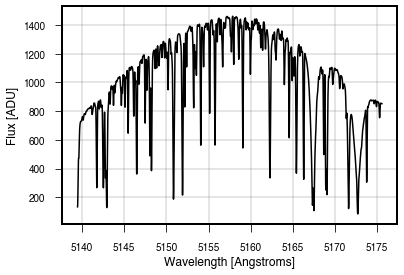

In [4]:
spec = series[0]
pl.plot(spec['wavelength'], spec['flux'], 'k-')

pl.xlabel('Wavelength [Angstroms]')
pl.ylabel('Flux [ADU]')

Now we'll overplot the second spectrum in the series and zoom in on a region to visualize the offset between them.

(5150, 5155)

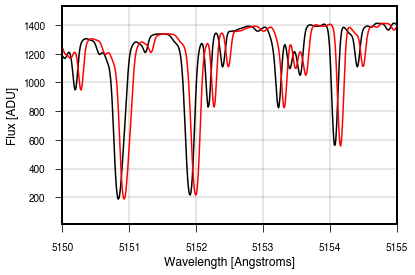

In [5]:
spec = series[0]
spec2 = series[1]
pl.plot(spec['wavelength'], spec['flux'], 'k-')
pl.plot(spec2['wavelength'], spec2['flux'], 'r-')

pl.xlabel('Wavelength [Angstroms]')
pl.ylabel('Flux [ADU]')

pl.xlim(5150, 5155)

Next we will calculate the cross correlation function between our 'model' spectrum (first in the list), and the second spectrum in the list.

In [6]:
model = series[0]
ref_flux = model['flux'].values
ref_wav = model['wavelength'].values

spectrum = series[1]
flux = spectrum['flux'].values
wav = spectrum['wavelength'].values

nwav = flux.size

# First we need to convert target and model spectra to constant log-lambda scale
wav, flux, dvel = loglambda(wav, flux)

# Build spline object for resampling the model spectrum
ref_spline = InterpolatedUnivariateSpline(ref_wav, ref_flux)
ref_flux = ref_spline(wav)

In [7]:
def ccf(ref_flux, flux, dvel, nwav):
    # Perform cross-correlation.
    # If `lag` is negative, the observed spectrum need to
    # be blue-shifted in order to line up with the observed
    # spectrum. Thus, to put the spectra on the same scale, the
    # observed spectrum must be red-shifted, i.e. vmax is positive.
    flux -= np.mean(flux)
    ref_flux -= np.mean(ref_flux)
    lag = np.arange(-nwav + 1, nwav) 
    dvel = -1.0 * lag * dvel
    a = ref_flux
    b = flux

    # cross correalte a against b
    # here a is ref_flux and b is flux
    # should behave similar to scipy.signal.correlate or np.correlate
    # uses FFT to speed things up
    # zero-padding the vectors to length 2N−1, where N = length of vector (array= integer power of 2 ideal)
    # need zero-padding because the FFT method is actually circular cross-correlation
    # meaning the signal wraps around at the ends. 
    # add enough zeros to get rid of the overlap, to simulate a signal that is zero out to infinity.

    # normalize both arrays
    # may not need, but may help when dealing with small, sub-pixel shifts
    # The dot product of a & b for a given lag is |a|*|b|*cos(theta). 
    # The norms of a & b are constant for circular shifts, 
    # so dividing them out leaves just the varying cosine of the angle theta.
    a=(a-np.min(a))/(np.max(a)-np.min(a))
    b=(b-np.min(b))/(np.max(b)-np.min(b))

    # compute the Fast Fourrier Transform 
    f_a=np.fft.fft(a)
    f_b=np.fft.fft(b)

    # get the complex conjugate
    f_a_c=np.conj(f_a)

    # Convolution Theorem: The Fourier transform of the convolution is the
    # product of the two Fourier transforms

    # Correlation theorem: multiplying the Fourier transform of
    # one function by the complex conjugate of the Fourier transform of the other gives the
    # Fourier transform of their correlation
    # The inverse then brings us back to the original domain
    c_corr=np.fft.ifft(f_a_c*f_b)

    # FFT cross corr method gives the cyclic cross-correlation
    # "first n points in c_corr[0..2*n] stored in wrap-around order, i.e., correlations at increasingly
    # negative lags are in c_corr[n] on down to c_corr[n/2+1], while correlations at increasingly positive
    # lags are in c_corr[0] (zero lag) on up to c_corr[n/2]." --> Numerical Recipes in C
    # to get the linear correlation, need to circularly rotate the data
    # this puts the peaks of the signal together 
    c_corr=np.abs(np.roll(c_corr,len(c_corr) // 2))
    # above does the same as np.fft.fftshift
    # note that the shift occurs on a pixel/array element level, so len/2 has to be an integer 
    # so enforce floor/int division here

    # normalising, may help peak fitting 
    # also crop the delta velocity array to match the shape of the correlation function
    corr=(c_corr-np.min(c_corr))/(np.max(c_corr)-np.min(c_corr))
    s = int(len(corr)/2)
    e = -s+1
    dv = -dvel[s:e]
    
    return (dv, corr)

dv, corr = ccf(ref_flux, flux, dvel, nwav)

Text(0, 0.5, 'Cross Correlation [arbitrary units]')

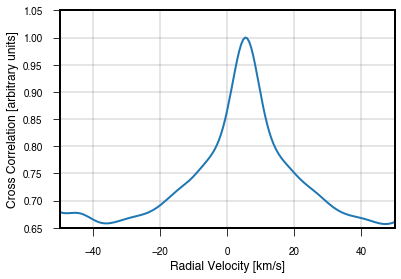

In [8]:
# plot the cross correlation as a function of 
# velocity shift
pl.plot(dv, corr, lw=2)
pl.xlim(-50, 50)
pl.ylim(0.65, 1.05)

pl.xlabel('Radial Velocity [km/s]')
pl.ylabel('Cross Correlation [arbitrary units]')

The peak in the cross correlation is clearly detected and indicates that spectrum 2 is redshifted by about 5 km/s relative to the first spectrum.

# Activity

1. Develop a method to precisely locate the peak of the cross correlation function above. BONUS: estimate the uncertainty of your velocities.

1. Measure the radial velocity for each spectrum in the series relative to the first spectrum and plot the series of velocities.

In [9]:
def peak_find(dv, corr, show_plot=False):
    """Locate and return RV at the peak of a CCF
    
    Args:
        dv (array): velocity array
        corr (array): cross correlation function
        show_plot (bool): (optional) show a plot of the fits?
        
    Returns:
        tuple: (RV at peak, estimate of uncertainty)
    """
    
    # We'll fit a polynomial around the peak location several times
    # each time we will add more data around the peak and re-fit
    # we'll get some (albeit not the best) estimate of uncertainty
    # by looking at the standard deviation between those fits. 
    # In this case, the simulated, noisless spectra produce very small
    # uncertainties.
    rvs = []
    for i in range(2, 16):
        # find the max and crop +/- i pixels around it
        m = np.argmax(corr)
        corr_crop = corr[m-i:m+i+1]
        dv_crop = dv[m-i:m+i+1]

        # fit a 2nd order polynomial around the peak
        p = np.polyfit(dv_crop, corr_crop, 2)
        fit_line = np.polyval(p, dv_crop)

        # get derivitive of polynomial and find root of derivitive
        deriv = np.polyder(p, 1)
        zero = np.roots(deriv)
        
        if show_plot:
            pl.plot(dv_crop, corr_crop, 'ko')
            pl.plot(dv_crop, fit_line, 'b-')
            pl.axvline(zero, color='r', lw=0.5)

        rvs.append(zero)
    
    rv = np.median(rvs)
    err = np.std(rvs)
    
    return (rv, err)
    

Text(0, 0.5, 'RV [km/s]')

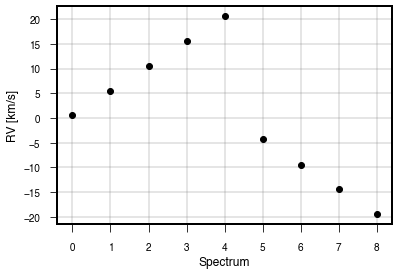

In [10]:
# Loop over all of the files that we loaded earlier and use our peak_find function to
# measure the RV. Notice that we re-cast some of the code in cells
# above as functions so that we can re-use it.

all_rvs = []
all_errs = []

for spec in series:
    # load spectrum columns
    wav = spec['wavelength'].values
    flux = spec['flux'].values

    # convert to log-lambda wavelength scale
    wav, flux, dvel = loglambda(wav, flux)
    nwav = flux.size
    
    # get cross correlation function
    dv, corr = ccf(ref_flux, flux, dvel, nwav)
    
    # find peak of CCF
    rv, err = peak_find(dv, corr)
    
    # append results to growing list
    all_rvs.append(rv)
    all_errs.append(err)
    

# plot the results
pl.errorbar(range(len(all_rvs)), all_rvs, yerr=all_errs, fmt='ko')
pl.xlabel('Spectrum')
pl.ylabel('RV [km/s]')